# 한-영 번역기 만들기 (v4.2: LSTM 적용)
---
## v4.0 대비 변경 사항
1.  **RNN 유닛 변경**: `GRU` -> `LSTM`
    - GRU와 다른 게이트 구조를 가진 LSTM을 사용하여 모델의 학습 양상에 변화를 주고자 합니다.
    - LSTM은 `hidden state`와 `cell state` 두 개를 사용하므로, 모델의 상태를 전달하는 로직이 수정됩니다.

In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

# !apt-get install -y fonts-nanum

# !pip install Korpora
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# !ls
# %cd Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab_light_220429.sh

# %cd ..

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import os
import re
import numpy as np
from konlpy.tag import Mecab
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import random
import time
from tqdm import tqdm

import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


### 데이터 불러오기 (train, dev, test)

In [3]:
data_dir = 'data'

train_kor_path = os.path.join(data_dir, 'korean-english-park.train.ko')
train_eng_path = os.path.join(data_dir, 'korean-english-park.train.en')
dev_kor_path = os.path.join(data_dir, 'korean-english-park.dev.ko')
dev_eng_path = os.path.join(data_dir, 'korean-english-park.dev.en')
test_kor_path = os.path.join(data_dir, 'korean-english-park.test.ko')
test_eng_path = os.path.join(data_dir, 'korean-english-park.test.en')

with open(train_kor_path, "r") as f: train_kor_raw = f.read().splitlines()
with open(train_eng_path, "r") as f: train_eng_raw = f.read().splitlines()
with open(dev_kor_path, "r") as f: dev_kor_raw = f.read().splitlines()
with open(dev_eng_path, "r") as f: dev_eng_raw = f.read().splitlines()
with open(test_kor_path, "r") as f: test_kor_raw = f.read().splitlines()
with open(test_eng_path, "r") as f: test_eng_raw = f.read().splitlines()

### 전처리 및 토큰화 함수 정의

In [4]:
mecab = Mecab()

def preprocess_corpus(kor_sentence, eng_sentence):
    kor_sentence = kor_sentence.lower().strip()
    kor_sentence = re.sub(r"[^가-힣?.!,]+", " ", kor_sentence)

    eng_sentence = eng_sentence.lower().strip()
    eng_sentence = re.sub(r"([?.!,])", r" \1 ", eng_sentence)
    eng_sentence = re.sub(r'[^a-zA-Z?.!,]+', ' ', eng_sentence)
    eng_sentence = re.sub(r'\s+', ' ', eng_sentence)
    eng_sentence = '<start> ' + eng_sentence.strip() + ' <end>'

    return kor_sentence, eng_sentence

def tokenize_corpus(kor_raw, eng_raw, max_len=40):
    kor_corpus, eng_corpus = [], []
    cleaned_corpus = list(set(zip(kor_raw, eng_raw)))
    for kor, eng in cleaned_corpus:
        kor_prep, eng_prep = preprocess_corpus(kor, eng)
        kor_tokens = mecab.morphs(kor_prep)
        eng_tokens = eng_prep.split()
        if len(kor_tokens) <= max_len and len(eng_tokens) <= max_len:
            kor_corpus.append(kor_tokens)
            eng_corpus.append(eng_tokens)
    return kor_corpus, eng_corpus

train_kor_corpus, train_eng_corpus = tokenize_corpus(train_kor_raw, train_eng_raw)

### 단어 사전 구축 (Train set 기준)

In [5]:
def build_vocab(corpus, max_vocab_size=10000):
    counter = Counter()
    for sentence in corpus:
        counter.update(sentence)

    vocab = counter.most_common(max_vocab_size - 4)
    word_to_idx = {word: i+4 for i, (word, _) in enumerate(vocab)}

    word_to_idx['<pad>'] = 0
    word_to_idx['<unk>'] = 1
    word_to_idx['<start>'] = 2
    word_to_idx['<end>'] = 3

    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return word_to_idx, idx_to_word

kor_word_to_idx, kor_idx_to_word = build_vocab(train_kor_corpus)
eng_word_to_idx, eng_idx_to_word = build_vocab(train_eng_corpus)

### 모든 데이터셋을 숫자 시퀀스로 변환

In [6]:
def text_to_sequence(corpus, word_to_idx):
    sequences = []
    for sentence in corpus:
        sequence = [word_to_idx.get(word, word_to_idx['<unk>']) for word in sentence]
        sequences.append(sequence)
    return sequences

dev_kor_corpus, dev_eng_corpus = [], []
for kor, eng in zip(dev_kor_raw, dev_eng_raw):
    kor_prep, eng_prep = preprocess_corpus(kor, eng)
    dev_kor_corpus.append(mecab.morphs(kor_prep))
    dev_eng_corpus.append(eng_prep.split())

test_kor_corpus, test_eng_corpus = [], []
for kor, eng in zip(test_kor_raw, test_eng_raw):
    kor_prep, eng_prep = preprocess_corpus(kor, eng)
    test_kor_corpus.append(mecab.morphs(kor_prep))
    test_eng_corpus.append(eng_prep.split())

train_kor_sequences = text_to_sequence(train_kor_corpus, kor_word_to_idx)
train_eng_sequences = text_to_sequence(train_eng_corpus, eng_word_to_idx)
dev_kor_sequences = text_to_sequence(dev_kor_corpus, kor_word_to_idx)
dev_eng_sequences = text_to_sequence(dev_eng_corpus, eng_word_to_idx)
test_kor_sequences = text_to_sequence(test_kor_corpus, kor_word_to_idx)
test_eng_sequences = text_to_sequence(test_eng_corpus, eng_word_to_idx)

## Step 2. 모델 설계 및 데이터셋 준비

In [7]:
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.src_sequences[idx]), torch.tensor(self.trg_sequences[idx])

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=kor_word_to_idx['<pad>'])
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=eng_word_to_idx['<pad>'])
    return src_padded, trg_padded

BATCH_SIZE = 64

train_dataset = TranslationDataset(train_kor_sequences, train_eng_sequences)
valid_dataset = TranslationDataset(dev_kor_sequences, dev_eng_sequences)
test_dataset = TranslationDataset(test_kor_sequences, test_eng_sequences)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

### Attention 기반 Seq2Seq 모델 설계 (LSTM 적용)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=kor_word_to_idx['<pad>'])
        self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)

        # 양방향 LSTM의 마지막 은닉 상태와 셀 상태를 결합하여 디코더로 전달
        hidden = hidden.view(self.n_layers, 2, -1, self.hidden_dim)
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
        hidden = torch.tanh(self.fc(hidden))

        cell = cell.view(self.n_layers, 2, -1, self.hidden_dim)
        cell = torch.cat((cell[:, 0, :, :], cell[:, 1, :, :]), dim=2)
        cell = torch.tanh(self.fc(cell))

        return outputs, hidden, cell

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, query, values):
        query = query.unsqueeze(1)
        score = self.V(torch.tanh(self.W1(query) + self.W2(values)))
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * values
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector, attention_weights.squeeze(-1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=eng_word_to_idx['<pad>'])
        self.rnn = nn.LSTM((hidden_dim * 2) + emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        context_vector, attention_weights = self.attention(hidden[-1], encoder_outputs)
        context_vector = context_vector.unsqueeze(1)
        rnn_input = torch.cat((embedded, context_vector), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell, attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        src_len = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src_len).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell, attention = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t, :] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs, attentions

## Step 3. 모델 학습 및 검증

In [9]:
VOCAB_SIZE = 10000
INPUT_DIM = VOCAB_SIZE
OUTPUT_DIM = VOCAB_SIZE
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.6
DEC_DROPOUT = 0.6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attn = BahdanauAttention(HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=eng_word_to_idx['<pad>'], label_smoothing=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


### 학습 및 평가 함수 정의

In [10]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc="Training", leave=False)

    for i, batch in enumerate(progress_bar):
        src, trg = batch
        src, trg = src.long().to(device), trg.long().to(device)
        optimizer.zero_grad()
        output, _ = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.long().to(device), trg.long().to(device)
            output, _ = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### 학습 루프 실행

In [11]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    attention = attention.cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='viridis')
    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, rotation=90, fontproperties=fontprop)
    ax.set_yticks(range(len(translation)))
    ax.set_yticklabels(translation)
    ax.tick_params(labelsize=12)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate_and_show_attention(sentence, model, kor_word_to_idx, eng_idx_to_word, device, max_len=50):
    model.eval()
    tokens = mecab.morphs(sentence)
    src_indexes = [kor_word_to_idx.get(t, kor_word_to_idx['<unk>']) for t in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

    trg_indexes = [eng_word_to_idx['<start>']]
    attentions = torch.zeros(max_len, len(src_indexes)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell, attention = model.decoder(trg_tensor, hidden, cell, encoder_outputs)
        attentions[i] = attention.squeeze(0)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == eng_word_to_idx['<end>']:
            break

    trg_tokens = [eng_idx_to_word.get(i, '<unk>') for i in trg_indexes]
    translation = trg_tokens[1:-1]

    print(f'Original: {sentence}')
    print(f"Translated: {' '.join(translation)}")
    display_attention(tokens, translation, attentions[:len(translation)])

  * Best Val. Loss updated: 6.664
Epoch: 01 | Time: 3.0m 31s
	Current LR: 0.001000
	Train Loss: 6.673 | Train PPL: 790.630
	 Val. Loss: 6.664 |  Val. PPL: 783.601

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: the , , the , , the , , the , , the , .


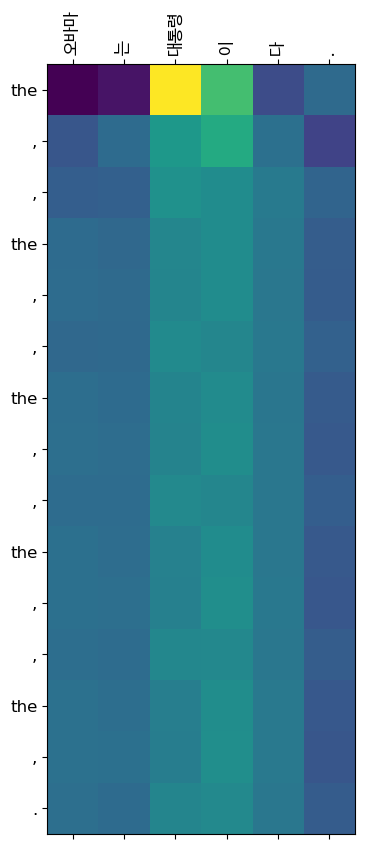

  * Best Val. Loss updated: 6.546
Epoch: 02 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 6.331 | Train PPL: 561.842
	 Val. Loss: 6.546 |  Val. PPL: 696.592

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the to the obama , obama , obama , obama , he was the to the .


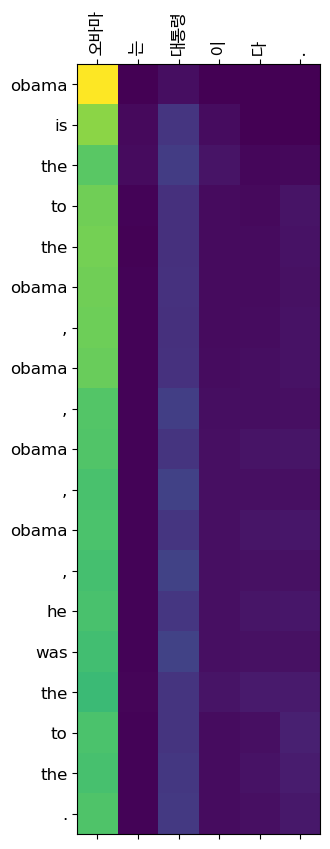

  * Best Val. Loss updated: 6.502
Epoch: 03 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 6.136 | Train PPL: 462.176
	 Val. Loss: 6.502 |  Val. PPL: 666.743

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama .


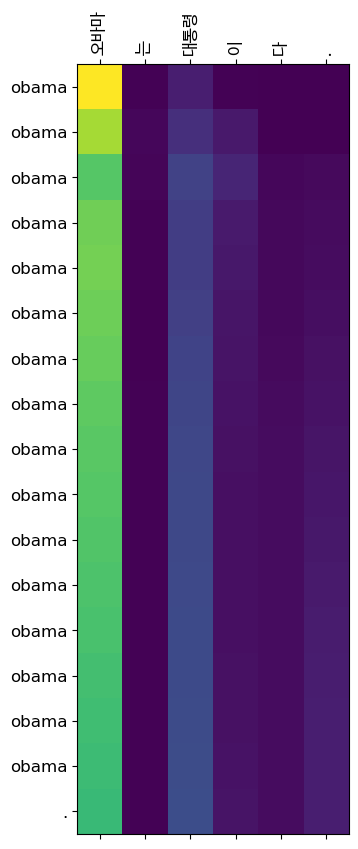

  * Best Val. Loss updated: 6.459
Epoch: 04 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 6.022 | Train PPL: 412.364
	 Val. Loss: 6.459 |  Val. PPL: 638.274

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama , obama , obama , obama , obama , obama , obama .


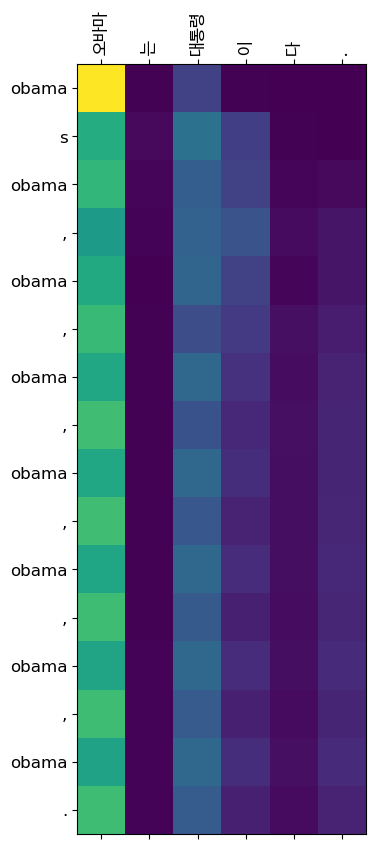

  * Best Val. Loss updated: 6.443
Epoch: 05 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 5.935 | Train PPL: 377.851
	 Val. Loss: 6.443 |  Val. PPL: 628.406

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama obama obama obama obama obama obama obama obama obama .


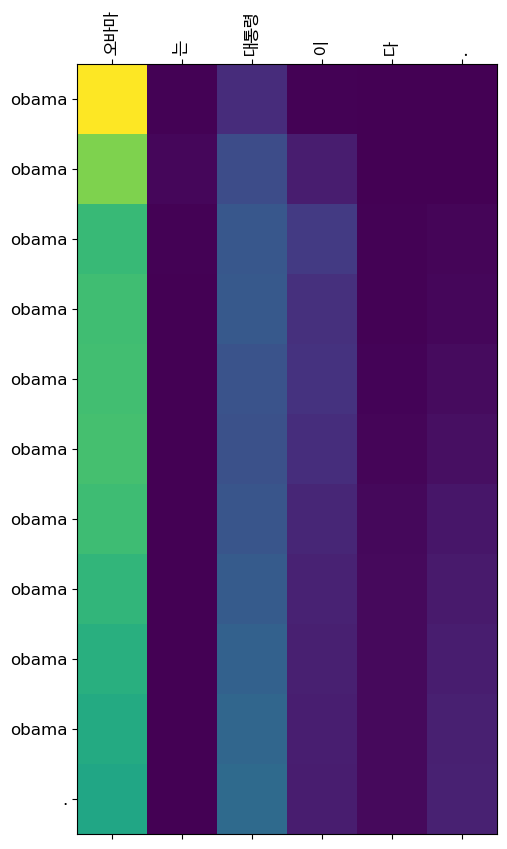

  * Best Val. Loss updated: 6.431
Epoch: 06 | Time: 3.0m 31s
	Current LR: 0.001000
	Train Loss: 5.853 | Train PPL: 348.363
	 Val. Loss: 6.431 |  Val. PPL: 620.970

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the president barack obama , obama , obama , obama , obama , obama , obama .


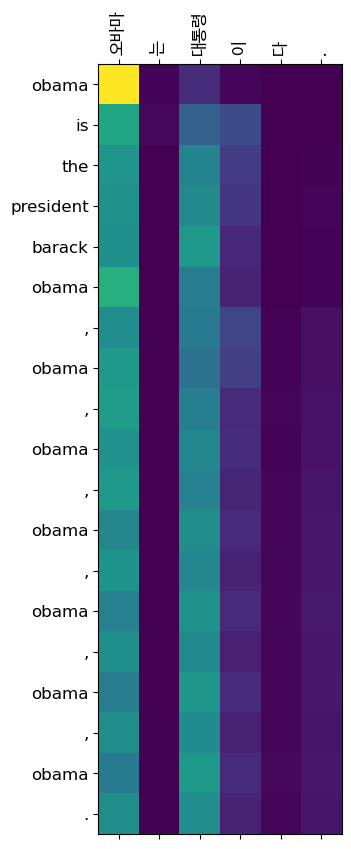

  * Best Val. Loss updated: 6.392
Epoch: 07 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 5.797 | Train PPL: 329.150
	 Val. Loss: 6.392 |  Val. PPL: 597.034

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the president barack obama , obama obama obama obama obama obama obama obama obama obama .


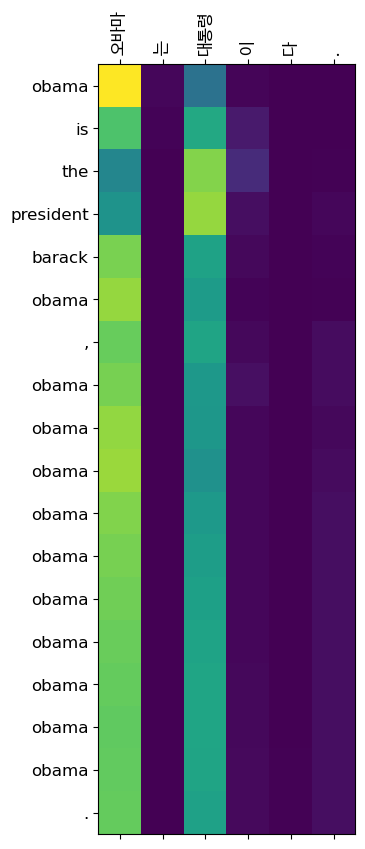

  * Best Val. Loss updated: 6.380
Epoch: 08 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 5.735 | Train PPL: 309.379
	 Val. Loss: 6.380 |  Val. PPL: 589.638

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is a president barack obama , obama , obama , obama , obama , obama , obama .


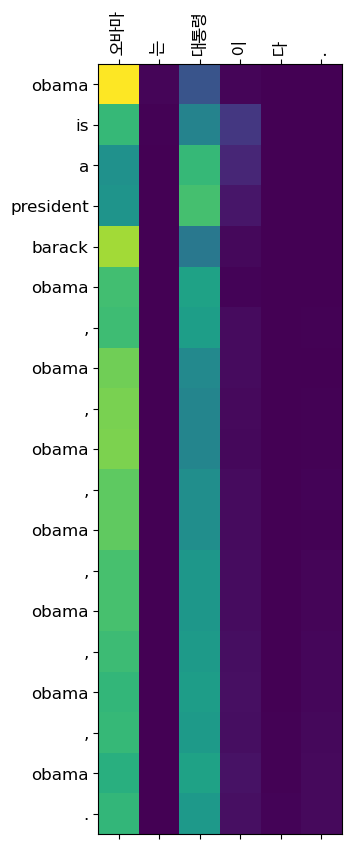

  * Best Val. Loss updated: 6.366
Epoch: 09 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 5.689 | Train PPL: 295.497
	 Val. Loss: 6.366 |  Val. PPL: 581.990

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is a president obama , obama , obama , president , obama , president , obama .


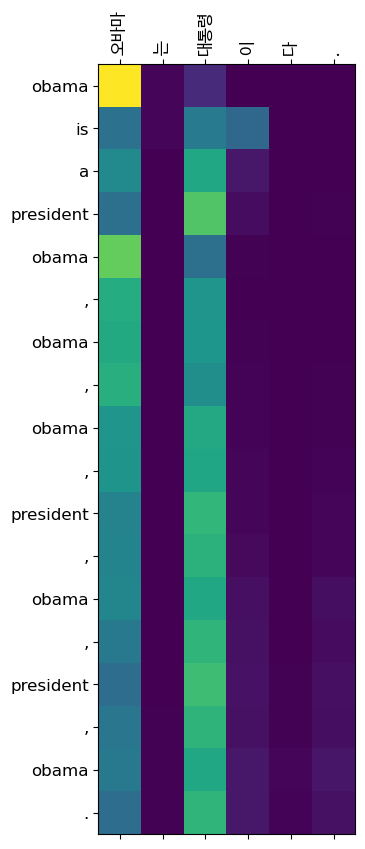

  * Best Val. Loss updated: 6.338
Epoch: 10 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 5.648 | Train PPL: 283.856
	 Val. Loss: 6.338 |  Val. PPL: 565.528

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is obama president obama obama obama obama obama obama obama obama obama obama , president obama obama .


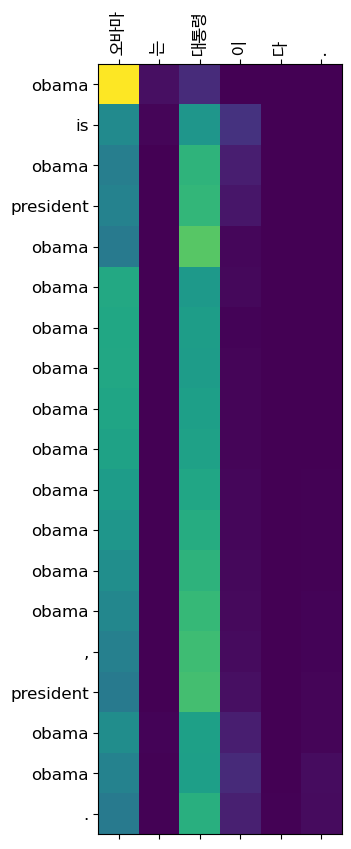

  * Best Val. Loss updated: 6.332
Epoch: 11 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 5.607 | Train PPL: 272.224
	 Val. Loss: 6.332 |  Val. PPL: 562.413

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is obama president obama obama , obama , obama is obama , obama .


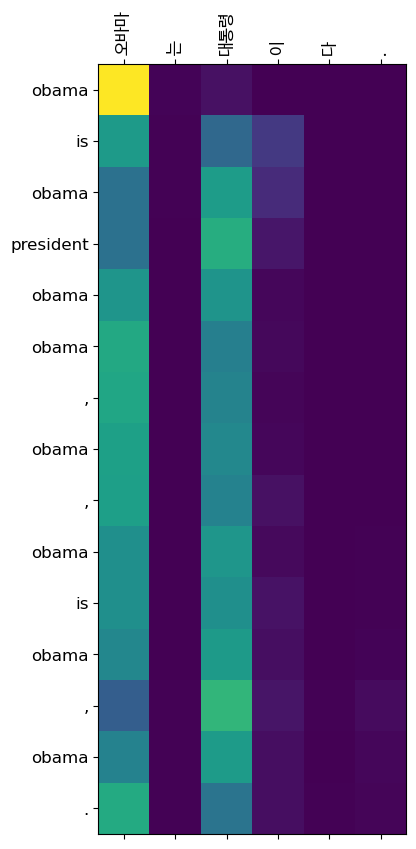

  * Best Val. Loss updated: 6.311
Epoch: 12 | Time: 3.0m 32s
	Current LR: 0.001000
	Train Loss: 5.562 | Train PPL: 260.453
	 Val. Loss: 6.311 |  Val. PPL: 550.426

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is obama president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama .


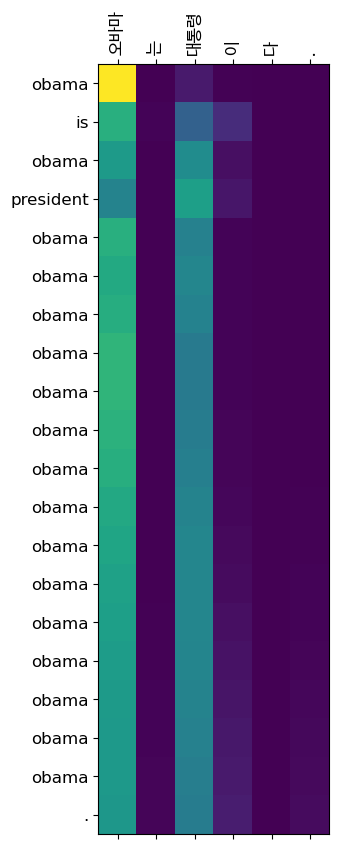

  * Early Stopping Counter: 1/3
Epoch: 13 | Time: 3.0m 35s
	Current LR: 0.001000
	Train Loss: 5.533 | Train PPL: 253.016
	 Val. Loss: 6.317 |  Val. PPL: 554.011

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the obama obama obama obama obama obama obama obama obama obama obama obama .


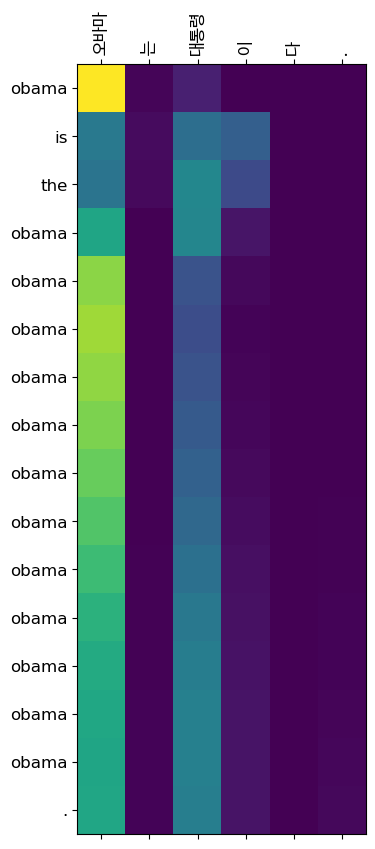

  * Early Stopping Counter: 2/3
Epoch: 14 | Time: 3.0m 34s
	Current LR: 0.000500
	Train Loss: 5.501 | Train PPL: 244.936
	 Val. Loss: 6.315 |  Val. PPL: 552.686

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the president obama obama obama obama , obama obama is obama , obama obama is obama .


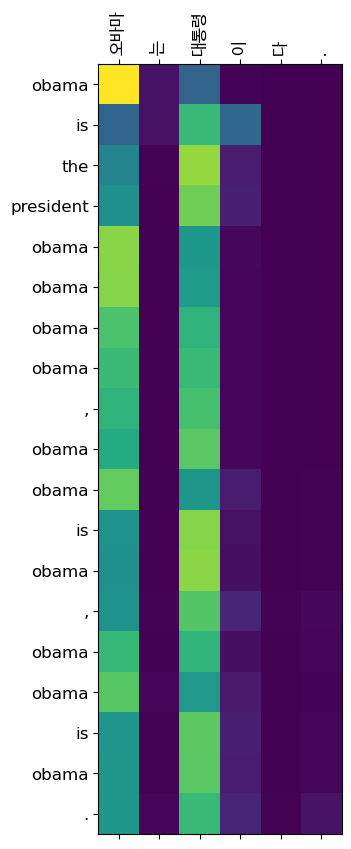

  * Best Val. Loss updated: 6.304
Epoch: 15 | Time: 3.0m 32s
	Current LR: 0.000500
	Train Loss: 5.441 | Train PPL: 230.754
	 Val. Loss: 6.304 |  Val. PPL: 546.869

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is obama s obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama .


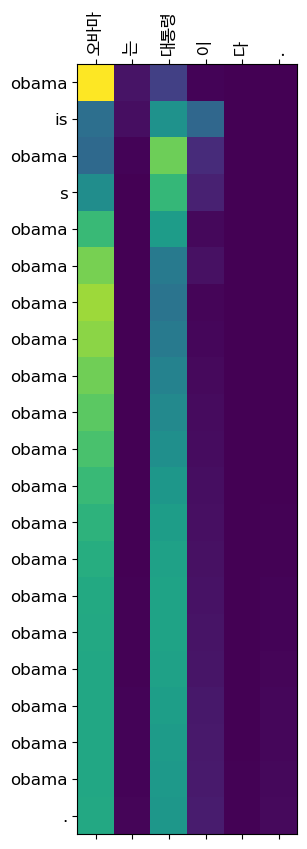

  * Best Val. Loss updated: 6.283
Epoch: 16 | Time: 3.0m 31s
	Current LR: 0.000500
	Train Loss: 5.418 | Train PPL: 225.452
	 Val. Loss: 6.283 |  Val. PPL: 535.294

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is president obama obama obama obama obama obama obama obama obama obama obama obama obama obama .


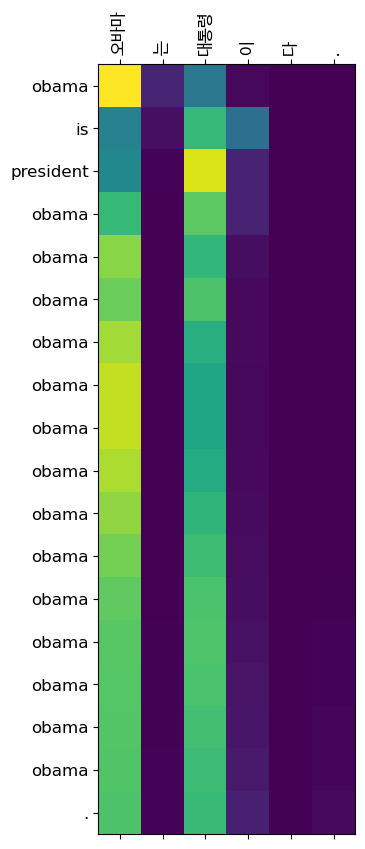

  * Early Stopping Counter: 1/3
Epoch: 17 | Time: 3.0m 33s
	Current LR: 0.000500
	Train Loss: 5.401 | Train PPL: 221.601
	 Val. Loss: 6.292 |  Val. PPL: 540.171

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama .


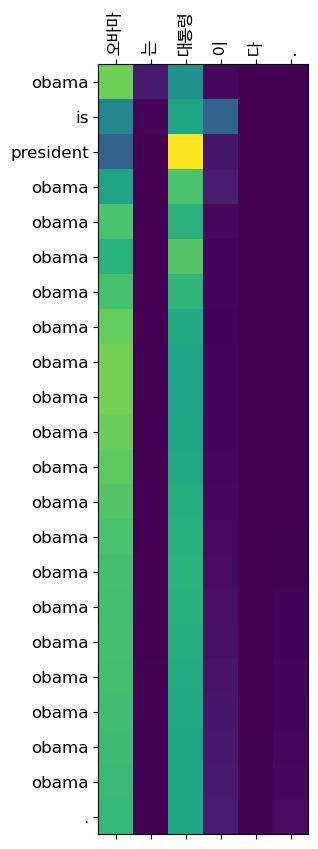

  * Early Stopping Counter: 2/3
Epoch: 18 | Time: 3.0m 32s
	Current LR: 0.000250
	Train Loss: 5.386 | Train PPL: 218.409
	 Val. Loss: 6.291 |  Val. PPL: 539.635

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is president obama obama obama obama obama obama obama obama , obama obama , obama obama , obama obama .


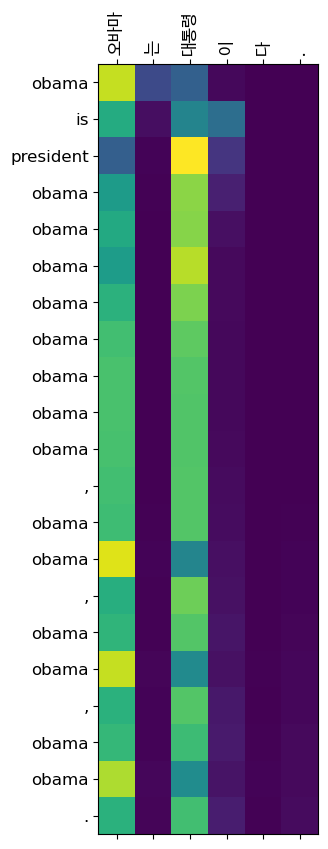

  * Best Val. Loss updated: 6.268
Epoch: 19 | Time: 3.0m 32s
	Current LR: 0.000250
	Train Loss: 5.352 | Train PPL: 211.097
	 Val. Loss: 6.268 |  Val. PPL: 527.365

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is president obama obama , obama obama , obama obama , obama obama , obama obama obama obama .


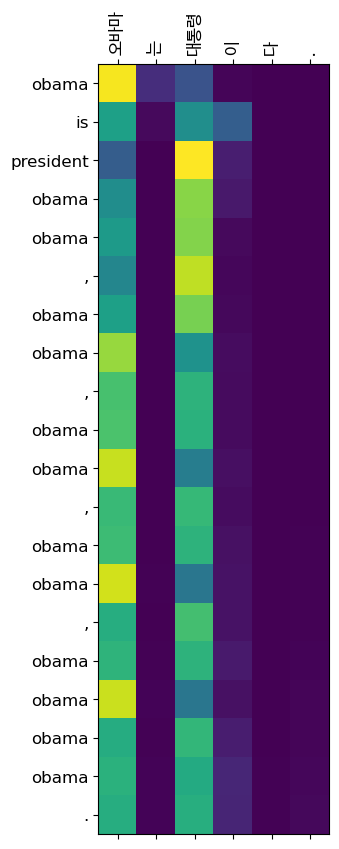

  * Early Stopping Counter: 1/3
Epoch: 20 | Time: 3.0m 32s
	Current LR: 0.000250
	Train Loss: 5.345 | Train PPL: 209.544
	 Val. Loss: 6.297 |  Val. PPL: 542.775

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is president president obama obama , obama obama , obama obama , obama obama , obama obama .


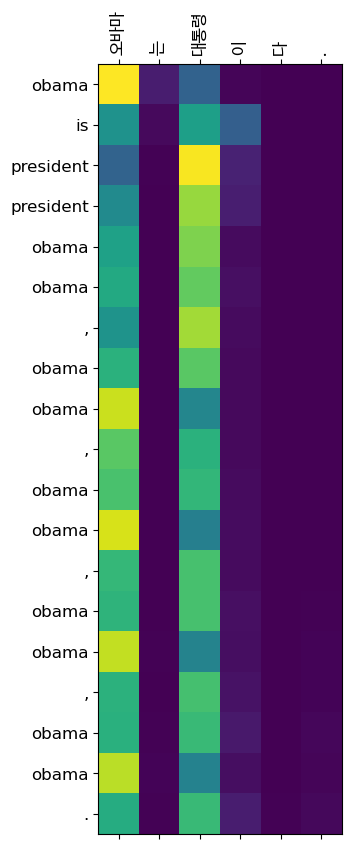

  * Early Stopping Counter: 2/3
Epoch: 21 | Time: 3.0m 32s
	Current LR: 0.000125
	Train Loss: 5.334 | Train PPL: 207.236
	 Val. Loss: 6.284 |  Val. PPL: 535.750

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is president president obama obama is obama , obama obama obama obama obama obama obama obama obama obama obama .


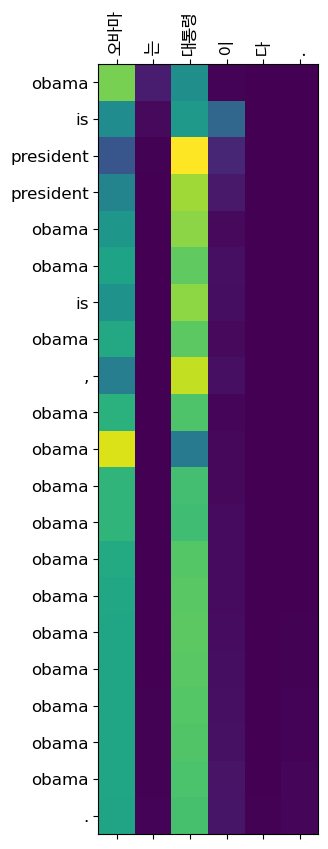

  * Early Stopping Counter: 3/3

[Early Stopping] Validation loss did not improve for 3 epochs. Stopping training...


In [12]:
N_EPOCHS = 100
CLIP = 1
PATIENCE = 3

best_valid_loss = float('inf')
patience_counter = 0
attention_check_sentence = "오바마는 대통령이다."

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    scheduler.step(valid_loss)
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'translator-ko-en-v4.2-lstm.pt')
        patience_counter = 0
        print(f"  * Best Val. Loss updated: {best_valid_loss:.3f}")
    else:
        patience_counter += 1
        print(f"  * Early Stopping Counter: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\n[Early Stopping] Validation loss did not improve for {PATIENCE} epochs. Stopping training...")
        break

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.0f}s')
    print(f'\tCurrent LR: {current_lr:.6f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

    print("\n--- Checking Attention Map ---")
    translate_and_show_attention(attention_check_sentence, model, kor_word_to_idx, eng_idx_to_word, device)
    model.train()

## Step 4. 최종 테스트 및 번역 시각화

In [13]:
model.load_state_dict(torch.load('translator-ko-en-v4.2-lstm.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |')

| Test Loss: 6.342 | Test PPL: 567.723 |


Original: 오바마는 대통령이다.
Translated: obama is president obama obama , obama obama , obama obama , obama obama , obama obama obama obama .


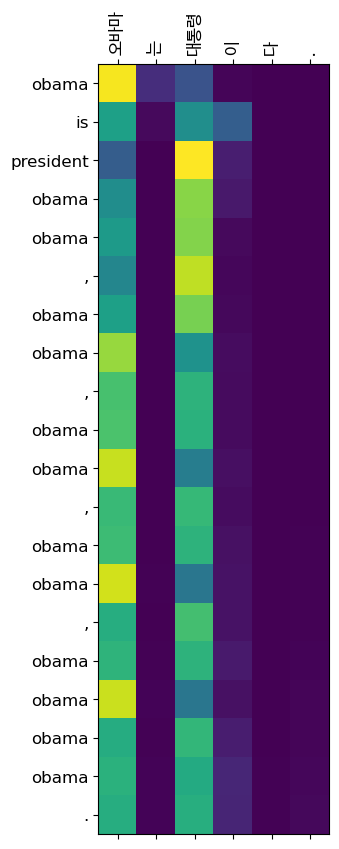


Original: 시민들은 도시 속에 산다.
Translated: the people are <unk> in the city of the city of the city of the city of the city of the city of the city .


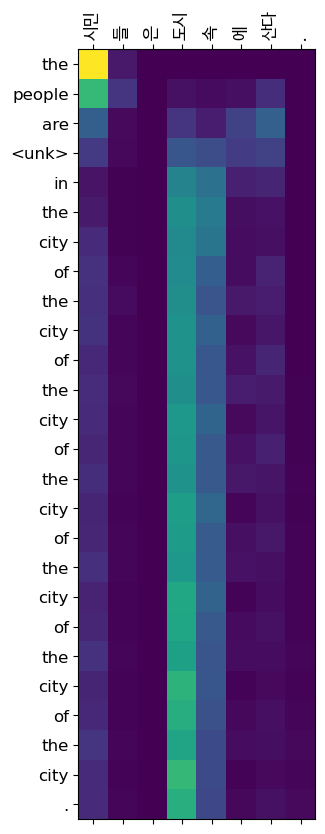


Original: 커피는 필요 없다.
Translated: no longer are not to , but , but , but , but , but not .


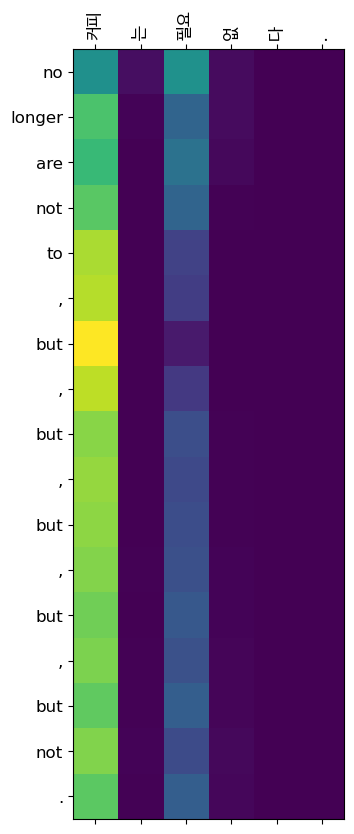


Original: 일곱 명의 사망자가 발생했다.
Translated: a least people died killed killed and killed people were killed killed and killed people died in the .


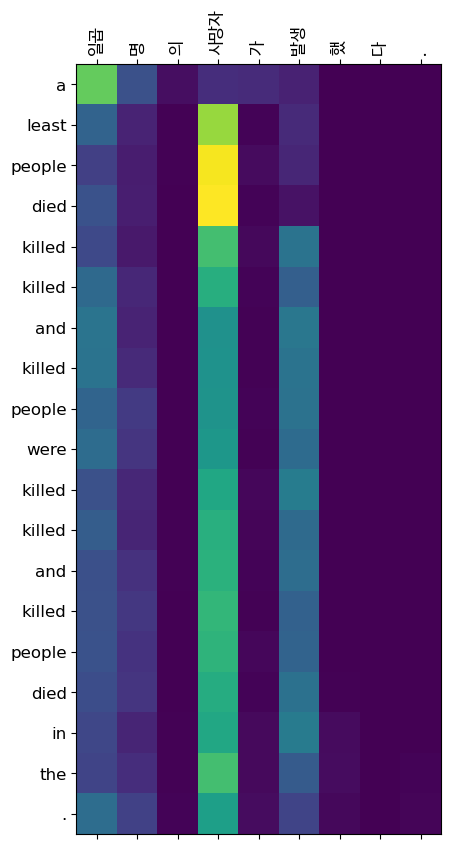

In [14]:
example_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

for sentence in example_sentences:
    translate_and_show_attention(sentence, model, kor_word_to_idx, eng_idx_to_word, device)
    print()